In [1]:
# Задача: построить классификатор, используя нейронную сеть

import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
random.seed(0)    # мы всегда будем использовать нулевую последовательность при вызове случайного генератора библиотеки random
np.random.seed(0)
torch.manual_seed(0)    # seed в PyTorch, отвечающий за расчет на CPU
torch.cuda.manual_seed(0)    # seed в PyTorch, отвечающий за расчет на GPU
torch.backends.cudnn.deterministic = True    # При расчетах на видеокарте используется библиотека cudnn

# Выставив параметры выше, мы можем гарантировать воспроизводимость наших экспериментов

In [3]:
# Загрузим датасет с винами

import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [4]:
X = wine.data
y = wine.target

In [5]:
df = pd.DataFrame(X)
df = df.rename(columns={0: 'Alcohol', \
                        1: 'Malic_acid', \
                        2: 'Ash', \
                        3: 'Alcalinity_of_ash', \
                        4: 'Magnesium', \
                        5: 'Total_phenols', \
                        6: 'Flavanoids', \
                        7: 'Nonflavanoid_phenols', \
                        8: 'Proanthocyanins', \
                        9: 'Color_intensity',
                        10: 'Hue', \
                        11: 'OD280/OD315', \
                        12: 'Proline'})

df.head()

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315,Proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [6]:
from sklearn.model_selection import train_test_split

# Сначала возьмем только 2 признака из 13, для удобства визуализации:

X_train, X_test, y_train, y_test = train_test_split(df[['Alcohol', 'Malic_acid']], y, test_size=0.3, shuffle=True, stratify=y)
# shuffle=True - перемешиваем датасет перед разбиением
# stratify=y предотвращаем проблему несбалансированности классов  

In [7]:
# Обернем наши выборки в Torch-тензоры:
X_train = torch.FloatTensor(X_train.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([124, 2])
torch.Size([54, 2])
torch.Size([124])
torch.Size([54])


In [9]:
# Реализуем класс WineNet для классификации
class WineNet(torch.nn.Module):    # наследуем класс от torch.nn.module
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)    # fully connected слой, 2 входа, на выходе n_hidden_neurons
        self.activ1 = torch.nn.Sigmoid()    # сигмоидная активация
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 3)    
        # На выходе этих 3-х нейронов будут некоторые числа, 
        # которые после этого мы передадим в Softmax и получим вероятности классов
        self.sm = torch.nn.Softmax(dim=1)    # инициализация Softmax, dim=1 - Softmax применяется построчно
        
    def forward(self, x):    # Функция forward будет реализовывать граф нашей нейросети
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        # Отметим, что здесь мы не использовали Softmax.
        return x

    def inference(self, x):    # функция inference необходима для подсчета вероятностей
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)    # Инициализируем нашу нейросеть с n_hidden_neurons = 5

In [10]:
loss = torch.nn.CrossEntropyLoss()    # Функция потерь - бинарная кросс-энтропия
# Эта функция использует не выходы после Softmax, а выходы нейронной сети, еще не пропущенные через Softmax

optimizer = torch.optim.Adam(wine_net.parameters(),   # Optimizer необходим для вычисления градиентных шагов
                            lr= 1.0e-3 )    # Передаем в него веса

In [11]:
# Каждую эпоху мы будем делать перемешивание нашего датасета, определять переменную order, 
# которая отвечает за порядок элементов

batch_size = 10    

for epoch in range(5000):
    order = np.random.permutation(len(X_train))    # order - это порядок индексов, который нужно применить к датасету
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]    # набор индексов, соответствующих текущему batch   
        
        x_batch = X_train[batch_indexes]    # вырезаем участки длиной batch_size
        y_batch = y_train[batch_indexes]    # вырезаем участки длиной batch_size
        
        preds = wine_net.forward(x_batch)    # пропускаем весь batch через нейросеть, получаем предсказания
        # (без софтмакса, выходы на последних 3-х нейронах)
        
        loss_value = loss(preds, y_batch)    # считаем loss на выходах нейронной сети и реальных значениях
        loss_value.backward()    # делаем backward, чтобы посчитать производную, результаты передаем в optimizer
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)    # смотрим, какому из выходов соответствовало максимальное значение
        # argmax - это номер нейрона - сравниваем его с истинным классом, который находится в y_test
        print((test_preds == y_test).float().mean())
# Ниже в результате работы кода мы видим растущее с числом пройденных эпох значение accuracy

C:\Users\pavel.molchanov\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


tensor(0.3889)
tensor(0.5000)
tensor(0.5370)
tensor(0.5556)
tensor(0.6111)
tensor(0.7037)
tensor(0.7593)
tensor(0.7593)
tensor(0.7778)
tensor(0.7778)
tensor(0.7593)
tensor(0.7778)
tensor(0.7963)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8333)
tensor(0.8704)
tensor(0.8519)
tensor(0.8519)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)


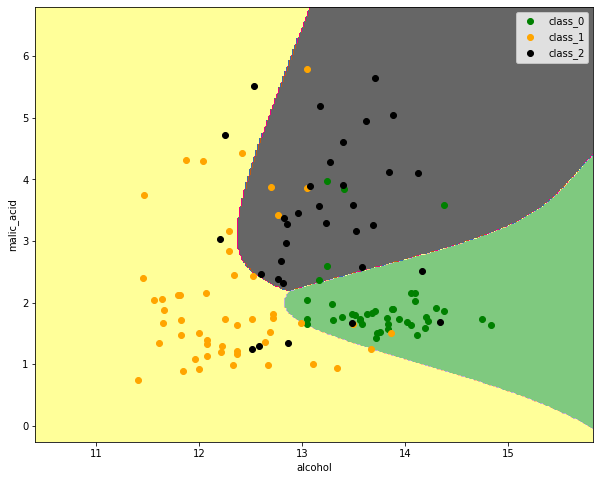

In [12]:
# Визуализируем результат:
# Точками обозначен тренировочный датасет, области - то, как нейросеть классифицировала бы соответствующие значения
plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['green', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

In [13]:
# Теперь воспользуемся всеми признаками
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, shuffle=True, stratify=y)    
# stratify=y - предотвращаем проблему несбалансированности классов  

In [14]:
# Обернем наши выборки в PyTorch-тензоры
X_train = torch.FloatTensor(X_train.to_numpy())
X_test = torch.FloatTensor(X_test.to_numpy())
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([124, 13])
torch.Size([54, 13])
torch.Size([124])
torch.Size([54])


In [16]:
# Реализуем класс WineNet для классификации
class WineNet(torch.nn.Module):    # наследуем класс от torch.nn.module
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)    # fully connected слой, 13 входов, на выходе n_hidden_neurons
        self.activ1 = torch.nn.Sigmoid()   
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 3)    
        self.sm = torch.nn.Softmax(dim=1)    # инициализация Softmax, dim=1 - Softmax применяется построчно
        
    def forward(self, x):    # Функция forward будет реализовывать граф нашей нейросети
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        # Отметим, что здесь мы не использовали Softmax.
        return x

    def inference(self, x):    # функция inference необходима для подсчета вероятностей
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(50)    # Инициализируем нашу нейросеть с n_hidden_neurons = 50

In [17]:
loss = torch.nn.CrossEntropyLoss()    # Функция потерь - бинарная кросс-энтропия
# Эта функция использует не выходы после Softmax, а выходы нейронной сети, еще не пропущенные через Softmax

optimizer = torch.optim.Adam(wine_net.parameters(),   # Optimizer необходим для вычисления градиентных шагов
                            lr= 1.0e-3 )    # Передаем в него веса

In [18]:
# Каждую эпоху мы будем делать перемешивание нашего датасета, определять переменную order, 
# которая отвечает за порядок элементов

batch_size = 10    

for epoch in range(5000):
    order = np.random.permutation(len(X_train))    # order - это порядок индексов, который нужно применить к датасету
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]    # набор индексов, соответствующих текущему batch   
        
        x_batch = X_train[batch_indexes]    # вырезаем участки длиной batch_size
        y_batch = y_train[batch_indexes]    # вырезаем участки длиной batch_size
        
        preds = wine_net.forward(x_batch)    # пропускаем весь batch через нейросеть, получаем предсказания
        # (без софтмакса, выходы на последних 3-х нейронах)
        
        loss_value = loss(preds, y_batch)    # считаем loss на выходах нейронной сети и реальных значениях
        loss_value.backward()    # делаем backward, чтобы посчитать производную, результаты передаем в optimizer
        
        optimizer.step()
        
    if epoch % 100 == 0:    # Каждые 100 эпох мы будем вычислять метрики на тестовом датасете
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)    # смотрим, какому из выходов соответствовало максимальное значение
        # argmax - это номер нейрона - сравниваем его с истинным классом, который находится в y_test
        print((test_preds == y_test).float().mean())    # Accuracy

tensor(0.3333)
tensor(0.9259)
tensor(0.9259)
tensor(0.9259)
tensor(0.9444)
tensor(0.9259)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)
tensor(0.9444)


In [19]:
# Как мы видим, при использовании 13 признаков вместо 2 и увеличении n_hidden_neurons, accuracy поднялась с 83% до 94%